# **Shoe Brand Detection Using Image Classification**


## Business Prespective

 

  Marketing places a key role in business growth. Every brand is coming up with new and innovative ideas to market their own products. The project we are doing here plays an important job in marketing of shoe brand. We are using image classification to predict the brand of the shoes. This is a small part of the project which can be used for real life brand prediction. In this project we are mainly focusing on 4 brands(Adidas,Balenciaga,Nike,Puma).




  Based on the image we give the model will try to predict which brand it belongs to. In the long run of this project we can use the larger dataset which has the images of all the famous brand and some of the least famous brand. We could use this data in creating a real time processing system which can predict the brand.
  Using that we can create a stats of the use of the brand. Compare them based on a daily basis which will give as the most used brand
This data can be used for the marketing of brand which leads in most usage.
The similar model can be used for other items such as cars,bikes etc.

Importing TensorFlow & necessary libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from glob import glob # returns all file paths that match a specific pattern
import cv2 
import imghdr #identifies different image file formats

**Link for the Dataset in Drive**

https://drive.google.com/drive/folders/1zAgoK-KZGevM3edbRVOXNr5sgrU1s3bj?usp=sharing

Importing Data from Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Shoe Dataset

In [ ]:
# re-size all the images to this
shoedata="/content/drive/MyDrive/DataSets/Shoe dataset/New_shoes"

In [ ]:
data_dir =shoedata

Required Shoe Extentions

In [ ]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

## Removing Unwanted images

Flitering the dataset we created and keeping the files with suitable format

In [ ]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path) #loads an image from the specified file
            tip = imghdr.what(image_path) #tests the image data contained in the file
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Loading the DATA

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(shoedata) #allows to load your data from directory

Found 2227 files belonging to 4 classes.


In [ ]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

Printing the random four data

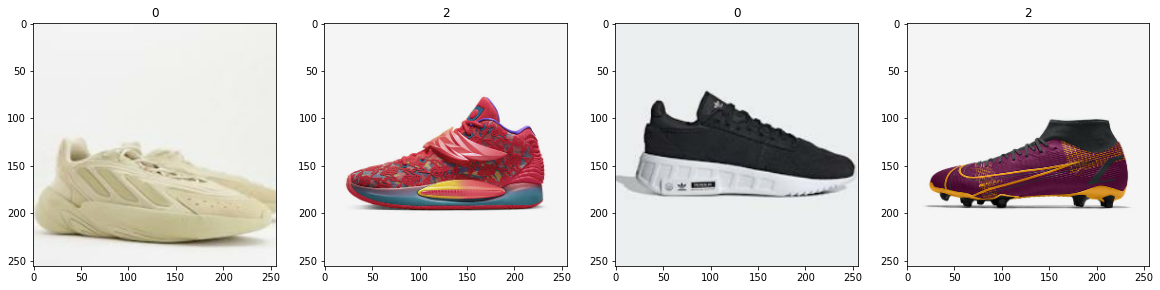

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Here are some shoes which are present in the dataset

## Creating a dataset

Assigning parameters

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

## Splitting the Data

Here the data is splitted as : 80% of the images for training, and 20% for validation.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=1,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2227 files belonging to 4 classes.
Using 1782 files for training.


We need to  provide `seed` argument, to make sure that there is no overlap between the training and validation subset.

In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=1,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2227 files belonging to 4 classes.
Using 445 files for validation.


Displays the Folder's Name

In [ ]:
class_names = train_ds.class_names
print(class_names)

['Adidas', 'Balenciaga', 'Nike', 'Puma']


Snip of Folders from the Drive 

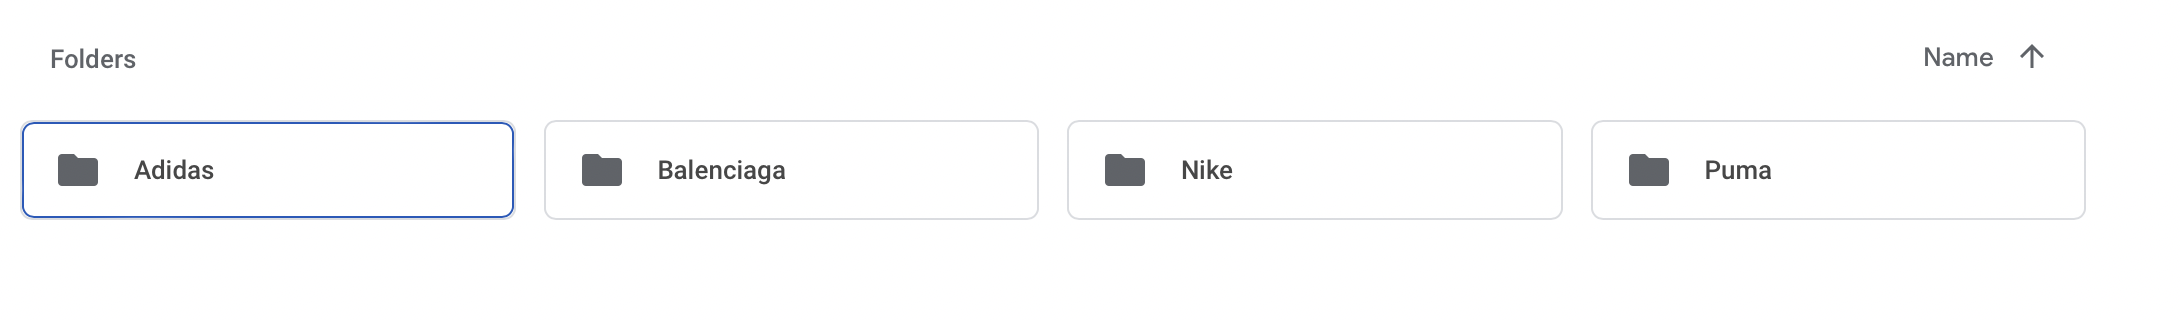

## Visualizing the data

Printing first nine images from the training dataset:

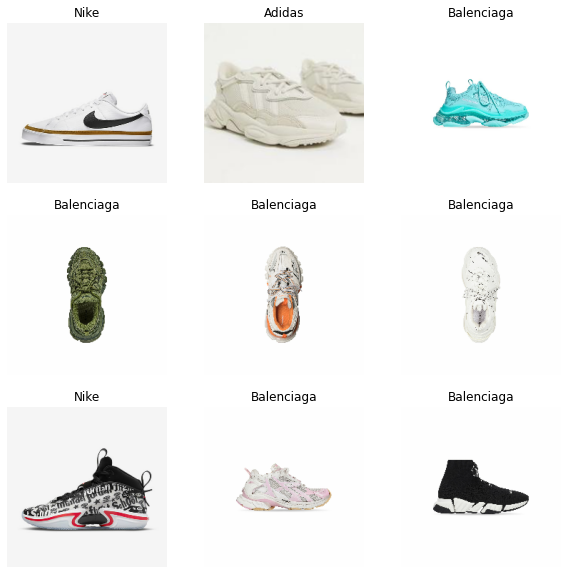

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Checking the Image Batch Size

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


## Autotuning the Data

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE #tunes the value dynamically at runtime.

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Dataset.cache** keeps the images in memory after they're loaded off disk during the first epoch. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.


**Dataset.prefetch** overlaps data preprocessing and model execution while training.

## Standardizing the data

Rescaling the values to be in the [0, 1] range by using *tf.keras.layers.Rescaling*

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image)) 

0.15000144 1.0


# Creating the Model

## **Model 1--Sequential Model**

The Sequential model is made up of three convolution blocks (Conv2D) that each have a max pooling layer (MaxPooling2D). A ReLU activation function ('relu') on top of a fully linked layer (Dense) with 128 units activates it.

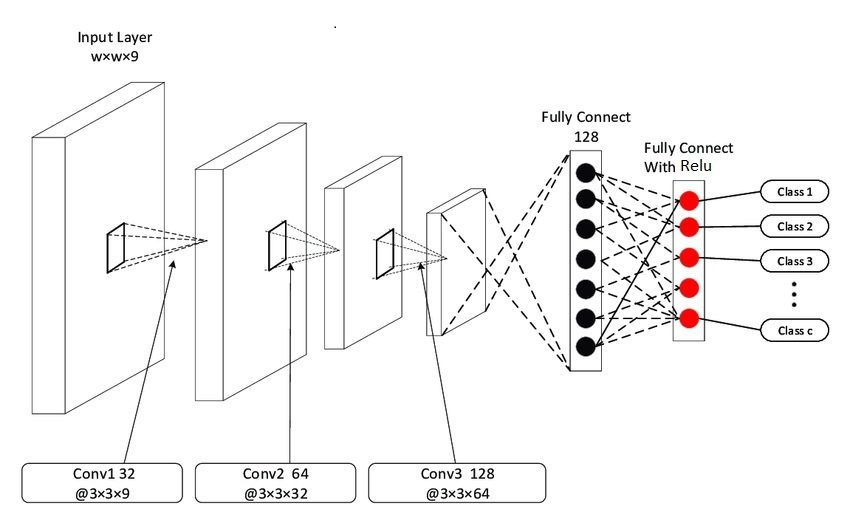

## Building the Model

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

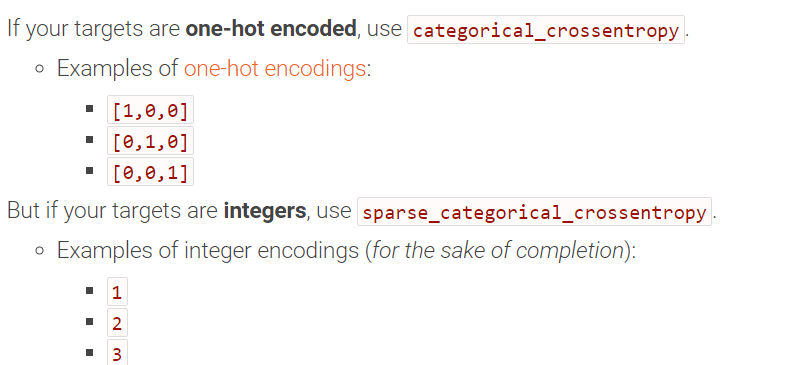

Since our code has integers,we are using *sparse categorical cross entropy* and Using *from_logits*=True may be more numerically stable.

## Compiling the model



In this model,the optimizer is *Adam*,since it has optimization algorithms, have faster computation time. Loss function is *SparseCategoricalCrossentropy* loss function. By passing the *metrics* parameter to Model.compile, you may observe the training and validation accuracy for each training period.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model-1 Summary



In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)      

## Training the Model-1

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
56/56 [==============================] - 6s 102ms/step - loss: 0.6190 - accuracy: 0.8086 - val_loss: 0.3079 - val_accuracy: 0.9191
Epoch 2/10
56/56 [==============================] - 3s 60ms/step - loss: 0.1767 - accuracy: 0.9405 - val_loss: 0.2486 - val_accuracy: 0.9034
Epoch 3/10
56/56 [==============================] - 3s 60ms/step - loss: 0.1189 - accuracy: 0.9624 - val_loss: 0.2035 - val_accuracy: 0.9191
Epoch 4/10
56/56 [==============================] - 3s 60ms/step - loss: 0.0585 - accuracy: 0.9759 - val_loss: 0.3265 - val_accuracy: 0.9236
Epoch 5/10
56/56 [==============================] - 3s 60ms/step - loss: 0.0477 - accuracy: 0.9854 - val_loss: 0.3327 - val_accuracy: 0.9169
Epoch 6/10
56/56 [==============================] - 3s 61ms/step - loss: 0.0311 - accuracy: 0.9916 - val_loss: 0.2464 - val_accuracy: 0.9483
Epoch 7/10
56/56 [==============================] - 3s 60ms/step - loss: 0.0073 - accuracy: 0.9983 - val_loss: 0.3294 - val_accuracy: 0.9528
Epoch 8/10
5

## Plot Performance of Model 1

Text(0.5, 1.0, 'Training and Validation Accuracy')

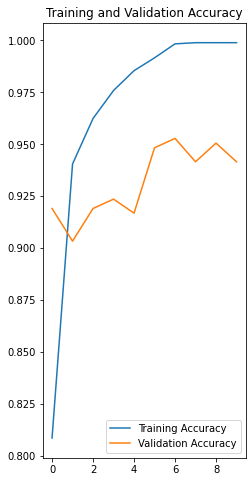

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

In [ ]:
x1 = acc
avg_m1 = np.mean(x1)
print("Average of accuracy of model 1 is", avg_m1)

Average of accuracy of model 1 is 0.9659371554851532


## **Model 2-- VGG16 Model**

The second model we are using is VGG16(Visual Geometry Group-16). 
VGG-16 is a convolutional neural network that is 16 layers deep.We can load a pretrained version of the network trained on more than a million images from the ImageNet database. This model has an image input size of 224-by-224

In [ ]:
#importing VGG16
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

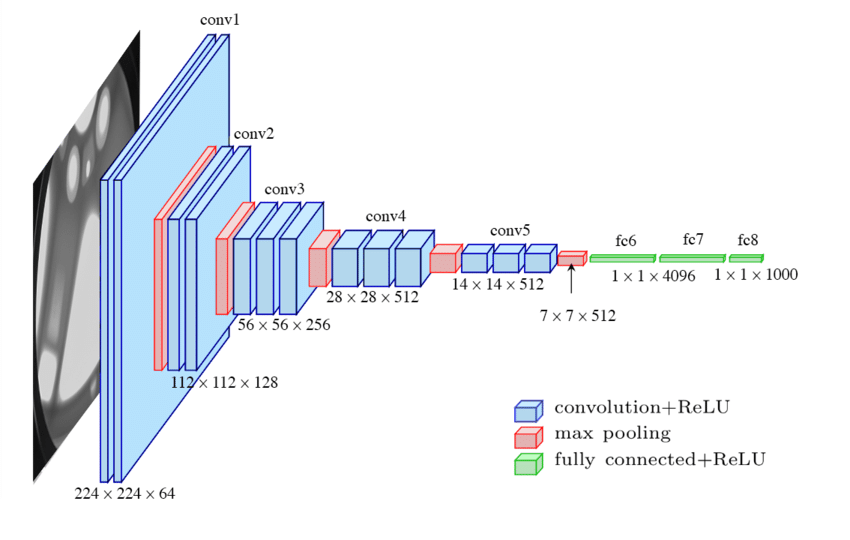

In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]


# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False
  

  
  # useful for getting number of classes
folders = glob('/content/drive/MyDrive/DataSets/Shoe dataset/New_shoes')
  

# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model2 = Model(inputs=vgg.input, outputs=prediction)


## Compiling and Summary of Model-2

In [ ]:
# tell the model what cost and optimization method to use
model2.compile(
  loss='SparseCategoricalCrossentropy',
  optimizer='adam',
  metrics=['accuracy']
  
)
# view the structure of the model
model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

## Training the Model-2

In [ ]:
epochs=10
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
56/56 [==============================] - 12s 203ms/step - loss: nan - accuracy: 0.2458 - val_loss: nan - val_accuracy: 0.2404
Epoch 2/10
56/56 [==============================] - 11s 192ms/step - loss: nan - accuracy: 0.2469 - val_loss: nan - val_accuracy: 0.2404
Epoch 3/10
56/56 [==============================] - 11s 197ms/step - loss: nan - accuracy: 0.2469 - val_loss: nan - val_accuracy: 0.2404
Epoch 4/10
56/56 [==============================] - 11s 203ms/step - loss: nan - accuracy: 0.2469 - val_loss: nan - val_accuracy: 0.2404
Epoch 5/10
56/56 [==============================] - 11s 200ms/step - loss: nan - accuracy: 0.2469 - val_loss: nan - val_accuracy: 0.2404
Epoch 6/10
56/56 [==============================] - 11s 196ms/step - loss: nan - accuracy: 0.2469 - val_loss: nan - val_accuracy: 0.2404
Epoch 7/10
56/56 [==============================] - 11s 201ms/step - loss: nan - accuracy: 0.2469 - val_loss: nan - val_accuracy: 0.2404
Epoch 8/10
56/56 [=======================

## Plot Performance of Model 2

Text(0.5, 1.0, 'Training and Validation Accuracy')

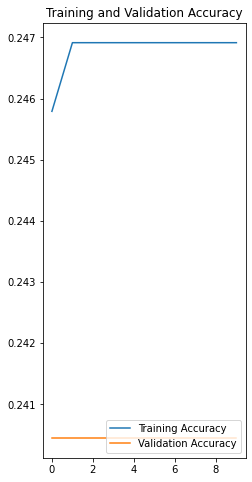

In [ ]:
acc2 = history.history['accuracy']
val_acc2 = history.history['val_accuracy']


loss2 = history.history['loss']
val_loss2 = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc2, label='Training Accuracy')
plt.plot(epochs_range, val_acc2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss2, label='Training Loss')
# plt.plot(epochs_range, val_loss2, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

In [ ]:
x2 = acc2
avg_m2 = np.mean(x2)
print("Average of accuracy of model 1 is", avg_m2)

Average of accuracy of model 1 is 0.24680134803056716


# **Model 3-ResNet50**

The third model we are using is ResNet 50. ResNet-50 is a convolutional neural network that is 50 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database.

In [ ]:
#importing ResNet50
from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input

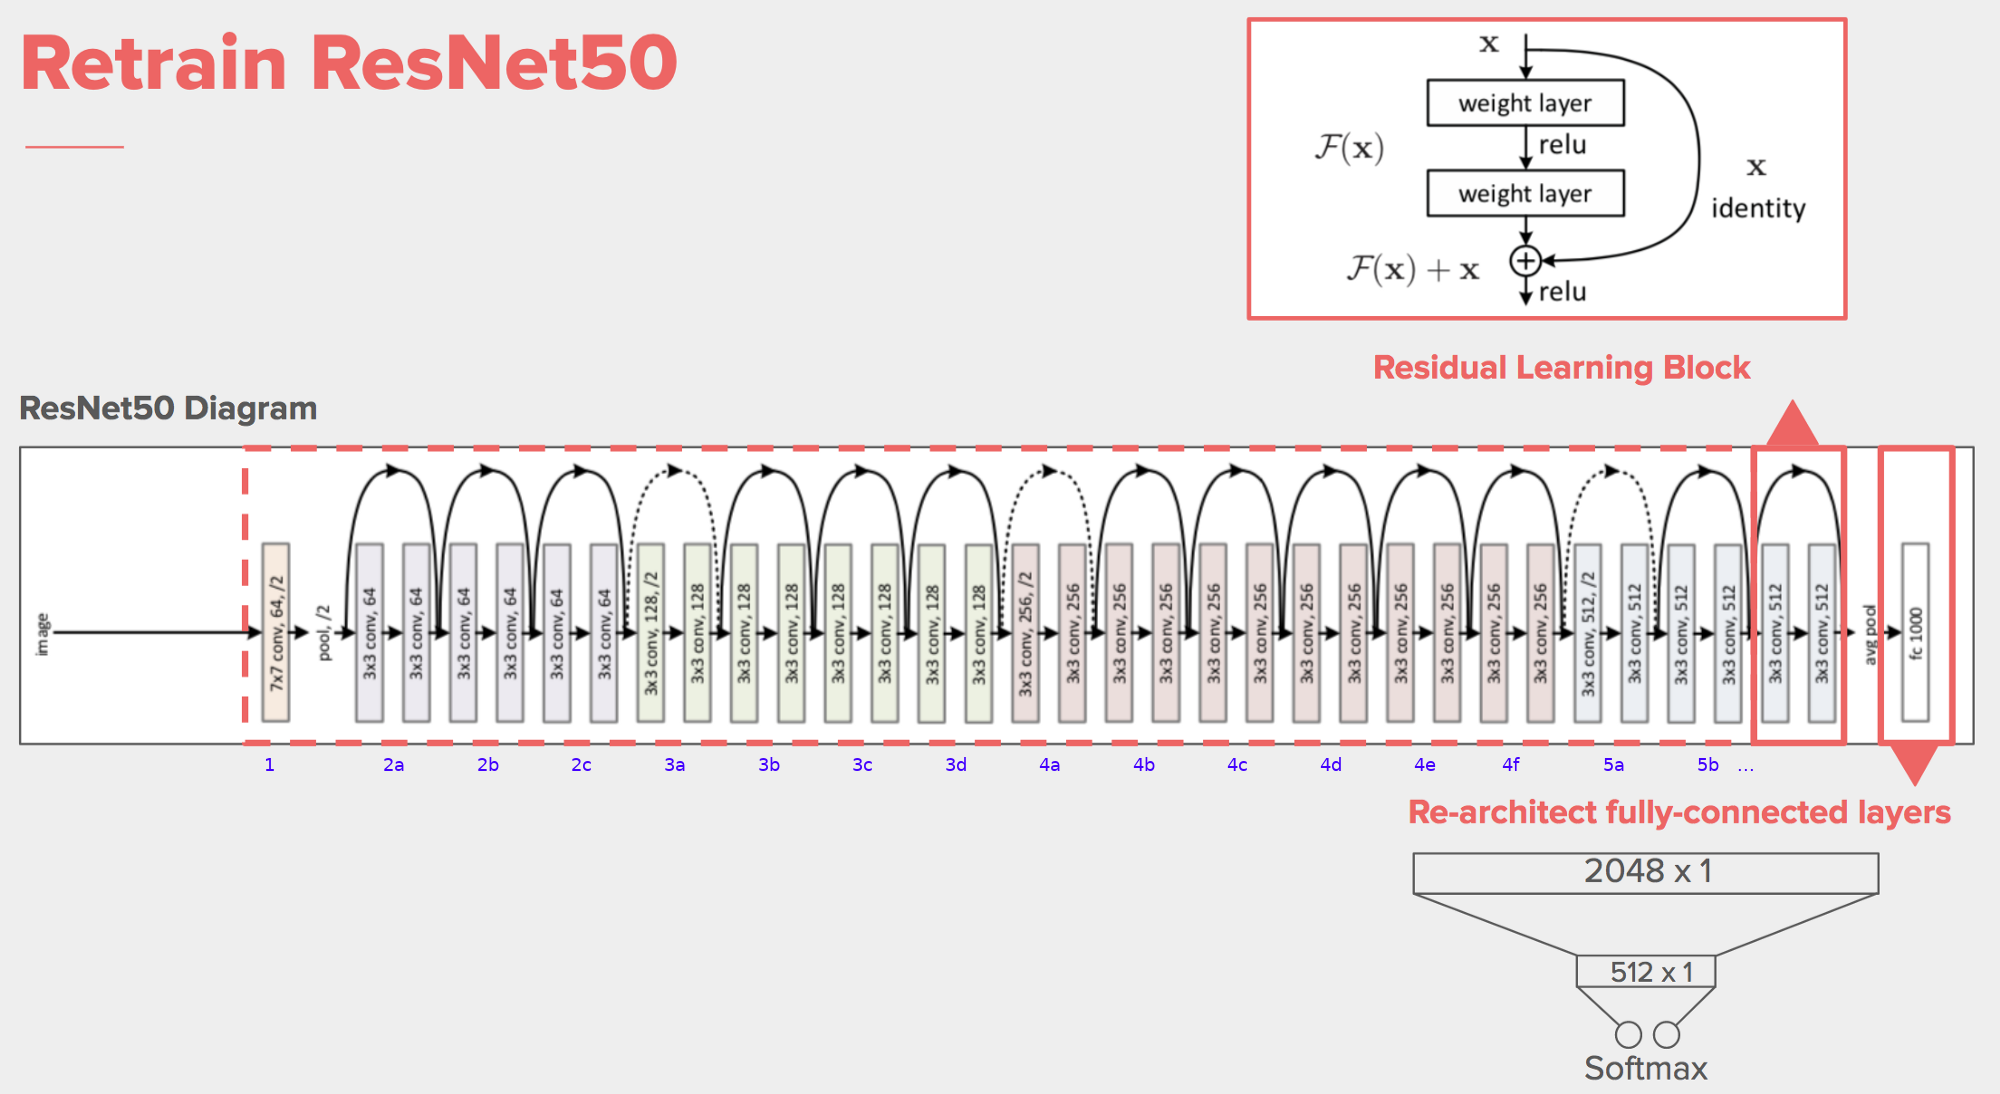

In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]


# add preprocessing layer to the front of VGG
ResNet50 = tf.keras.applications.ResNet50(include_top=True, weights="imagenet", input_tensor=None, input_shape=None, pooling=None, classes=1000)

#ResNet50 = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in ResNet50.layers:
  layer.trainable = False
  

  
  # useful for getting number of classes
folders = glob('/content/drive/MyDrive/DataSets/Shoe dataset/New_shoes')
  

# our layers - you can add more if you want
x = Flatten()(ResNet50.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model3 = Model(inputs=ResNet50.input, outputs=prediction)

## Compiling and Summary of Model-3

In [ ]:
# tell the model what cost and optimization method to use
model3.compile(
  loss='SparseCategoricalCrossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
# view the structure of the model
model3.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

## Training the Model-3

In [ ]:
epochs=10
history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
56/56 [==============================] - 11s 136ms/step - loss: nan - accuracy: 0.2469 - val_loss: nan - val_accuracy: 0.2404
Epoch 2/10
56/56 [==============================] - 7s 121ms/step - loss: nan - accuracy: 0.2469 - val_loss: nan - val_accuracy: 0.2404
Epoch 3/10
56/56 [==============================] - 7s 122ms/step - loss: nan - accuracy: 0.2469 - val_loss: nan - val_accuracy: 0.2404
Epoch 4/10
56/56 [==============================] - 7s 123ms/step - loss: nan - accuracy: 0.2469 - val_loss: nan - val_accuracy: 0.2404
Epoch 5/10
56/56 [==============================] - 7s 123ms/step - loss: nan - accuracy: 0.2469 - val_loss: nan - val_accuracy: 0.2404
Epoch 6/10
56/56 [==============================] - 7s 123ms/step - loss: nan - accuracy: 0.2469 - val_loss: nan - val_accuracy: 0.2404
Epoch 7/10
56/56 [==============================] - 7s 123ms/step - loss: nan - accuracy: 0.2469 - val_loss: nan - val_accuracy: 0.2404
Epoch 8/10
56/56 [=============================

## Plot Performance of Model-3

Text(0.5, 1.0, 'Training and Validation Accuracy')

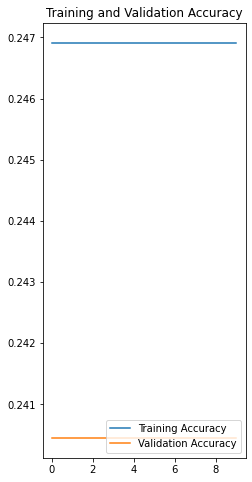

In [ ]:
acc3 = history.history['accuracy']
val_acc3 = history.history['val_accuracy']


loss3 = history.history['loss']
val_loss3 = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc3, label='Training Accuracy')
plt.plot(epochs_range, val_acc3, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss3, label='Training Loss')
# plt.plot(epochs_range, val_loss3, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

In [ ]:
x3 = acc3
avg_m3 = np.mean(x3)
print("Average of accuracy of model 1 is", avg_m3)

Average of accuracy of model 1 is 0.2469135820865631


### **Model Comparison**

We have taken the average of training accuracy of each model as avg_m1,avg_m2,avg_m3 respectively.

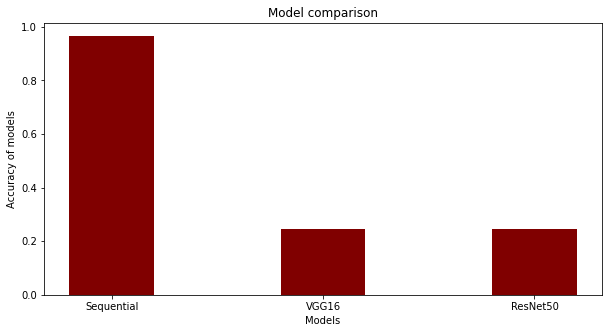

In [ ]:
# creating the dataset
data = {'Sequential':avg_m1, 'VGG16':avg_m2, 'ResNet50':avg_m3}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)

plt.xlabel("Models")
plt.ylabel("Accuracy of models")
plt.title("Model comparison")
plt.show()

## **Insights**

Based on the graph above we can clearly see that the Sequential model is out performing VGG16 and ResNet50. so we are considering the sequential model as the best model for the prediction part.

**Sequential Model Advantages:** It's the easiest way to build a model in Keras. It allows you to build a model layer by layer. We use the 'add()' function to add layers to our model. 

**VGG-16 Disadvantages**: It is very slow to train (the original VGG model was trained on the Nvidia Titan GPU for 2–3 weeks).
The size of VGG-16 trained imageNet weights is 528 MB. So, it takes quite a lot of disk space and bandwidth that makes it inefficient.

**Resnet50 Disadvantage:**The main disadvantage of ResNets are that for a deeper network, the detection of errors becomes difficult and requires more time for training

## Predicting New Data

Finally, we are using our model to detect an image that wasn't included in the training or validation sets.

**Example 1**

This image most likely belongs to Nike.


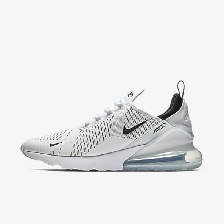

In [ ]:
findshoe_url = "https://static.nike.com/a/images/c_limit,w_592,f_auto/t_product_v1/209889d9-4910-4f06-9d07-18afa558b566/air-max-270-shoes-7RW243.png"
findss_path = tf.keras.utils.get_file('air-max-270-shoes-7RW243', origin=findshoe_url)

img = tf.keras.utils.load_img(
    findss_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {}."
    .format(class_names[np.argmax(score)])
)
img

**Example 2**

This image most likely belongs to Puma


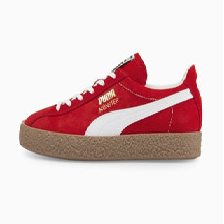

In [ ]:
findshoe_url = "https://media.gq-magazine.co.uk/photos/6278e3697d7f9a6cabdf4002/master/w_320%2Cc_limit/__04052021_PUMA_07.jpg"
findss_path = tf.keras.utils.get_file('__04052021_PUMA_07', origin=findshoe_url)

img = tf.keras.utils.load_img(
    findss_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {}"
    .format(class_names[np.argmax(score)])
)
img

**Example 3**

This image most likely belongs to Adidas


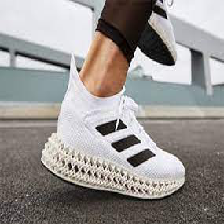

In [ ]:
findshoe_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSyFVTyyHs9o6MmCuVa7eHs4aDOK2VOOFaoTXP8bLKSYvMUtc1vS82QtGyxrq4S1_KAgqE&usqp=CAU"
findss_path = tf.keras.utils.get_file('ff', origin=findshoe_url)

img = tf.keras.utils.load_img(
    findss_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {}"
    .format(class_names[np.argmax(score)])
)
img

## **Conclusion:**

After analysing the results of all three models, we conclude that Sequential model is best for the detection of this data. We verified the model with three external images and it made the prediction correctly. 

Hence Sequential Model can be selected for the further development of the project.

# Deployment

Exporting the best model in h5 format for deployment purpose

In [ ]:
model.save('model.h5')

Files required for deployment


*   model.h5 
*   Templates(html)

*   static(css)
*   app.py(flask)


*   Requirement(version)








The deployment is done in AZURE WEB PLATFORM, After successful deployment can be seen LIVE

Snip of the webpage can be seen below
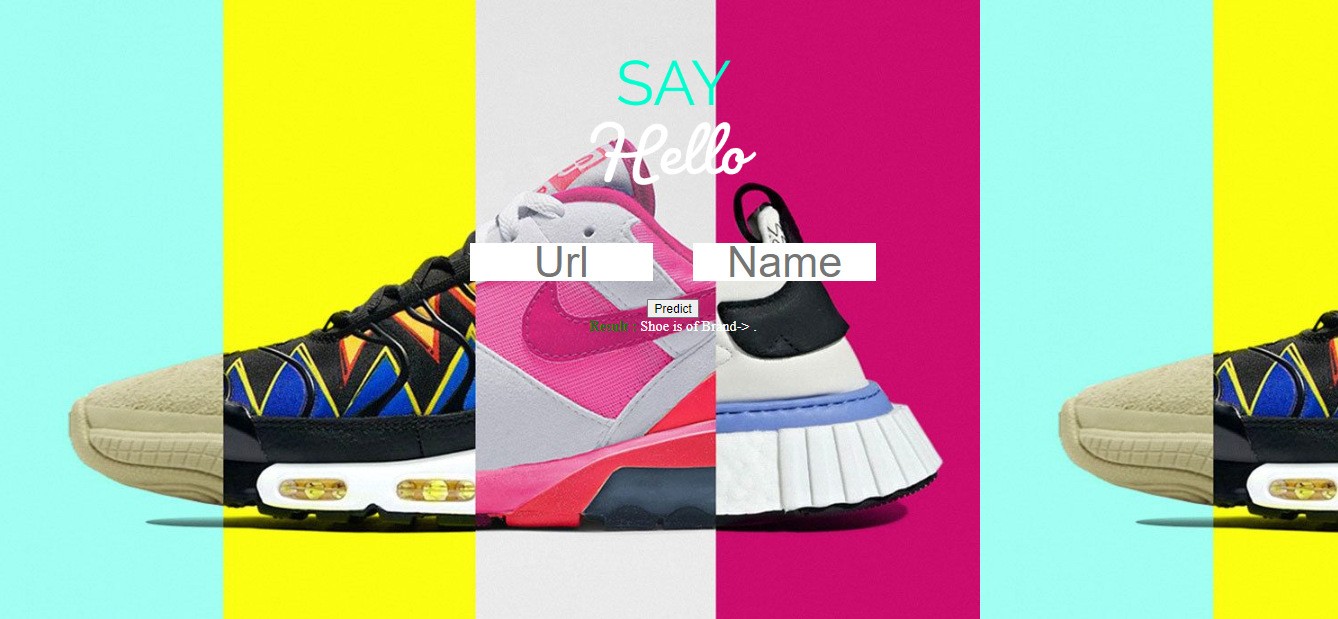